Import libraries

In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
import pandas as pd
import yfinance as yf
import datetime
from datetime import timedelta
from datetime import datetime as dt
from scipy import optimize as opt
import pandas as pd

 Classes for companies and options (same as in previous project expect small changes)


In [2]:
class Company: 
    '''
    This class represents a company.

    Attributes:
        comp_ticker: "AAPL" for instance
        starting_date: starting date of the computation (today: 2023-07-22 for instance)
        period_length: range of dates starting from today (over 1 year by default), synthax : 1y (for one year), 1mo (for 1 month)
    '''

    def __init__(self, comp_ticker, starting_date, period_length = "1y") : 
        self.ticker_name = comp_ticker
        self.starting_date = starting_date
        self.ticker = yf.Ticker(comp_ticker) # This object allows us to access yahoo finance's data
        self.data_shares = self.ticker.history(period=period_length)
        self.Options = [] # List containing all options that we will analyse for this company
        self.dividends = self.ticker.dividends # This gives us all dividends over period_length
        self.S0 = self.data_shares["Close"][-1] # share's close price at starting date
        


    def create_option(self,expiration_date,strike_price,option_type):
        '''
        This function creates an option and adds it to the self.Options list
        '''
        self.Options.append(Option(self,expiration_date,strike_price,option_type))


    @property
    def daily_returns(self):
        '''
        This function computes the daily return over the length of time of our stock prices
        Then it retrieves each daily return in a list
        '''
        d_returns = []
        stock_prices = list(self.data_shares["Close"])
        nb_days = len(stock_prices)
        for i in (range(nb_days-1)): 
            current_return = stock_prices[i+1]/stock_prices[i]
            d_returns.append(current_return)
        return d_returns
    
    @property
    def daily_volatility(self): 
        '''
        This function computes the volatility for each day. As you will see in the report
        and the ressources, Vt is actually the variance of each return, where the return at time t is a random variable
        Therefore, to compute the volatility at time t, we must compute the standard deviation 
        of the returns up to time t
        '''
        d_returns = self.daily_returns
        n = len(d_returns)
        volatilities = []
        for i in range(1,n+1): 
            returns = d_returns[:i]
            volatilities.append(np.std(returns)) 
        
        # As we don't have the initial value of the volatility (V0), we set it equal to V1
        
        volatilities[0] = volatilities[1]
        return volatilities
    
    


            
            

    
    



    @property
    def historical_volatility(self): 
        '''
        This function returns the computed annualized historical volatility based on the specified period_length (1y by default)
        '''
        close_prices = self.data_shares["Close"]
        n = len(close_prices)
        log_returns = []
        for i in range(n-1) : 
            log_r = np.log(close_prices[i+1]/close_prices[i]) # We use the log return, not the simple return
            log_returns.append(log_r)
        return np.std(log_returns) * np.sqrt(252)

    @property
    def dividend_yield(self) :
        '''
        This function represents the continuous compounded yield to maturity
        '''
        number_of_dividends = len(self.ticker.dividends)
        total_dividend = 0
        if number_of_dividends != 0 : 
            for i in range(number_of_dividends) : 
                total_dividend += self.ticker.dividends[i]
        return np.log(1+total_dividend/self.S0)

In [3]:
class Option:
    '''
    This class represents an option.

    Attributes:
        company: a Company class
        expiration_date: maturity date "2023-08-25" for instance
        strike_price: exercise price of the option
        option_type: either a call or a put
    '''

    # We defined manually risk-free rates based on US Treasury Bill for different time maturity.
    maturity_month = ["2023-08-18", "2023-08-25", "2023-09-15", "2023-10-20", "2023-11-17", "2023-12-15", "2024-01-19", "2024-02-16", "2024-06-21", "2025-01-17", "2025-06-20"]
    risk_free_rates = [0.05360, 0.05365, 0.05391, 0.05422, 0.05443, 0.05465, 0.05488, 0.05420, 0.05350, 0.04998, 0.04846]
    # We add this line to get a constant risk free rate as a mean of the rf over 2 years as it is difficult to estimate
    # To estimate it properly in a period of high instability
    cst_risk_free_rate = np.mean(np.array(risk_free_rates)) 
    risk_free_r = list(zip(maturity_month,risk_free_rates))
    risk_free_dict = dict(risk_free_r) # This dictionnary allows us to find the risk-free rate associated

    

    def get_number_of_days(self,start_date, end_date):
        '''
        This function computes the number of days till maturity (between start_date and end_date)
        '''
        start_date_1 = datetime.datetime.strptime(start_date, "%Y-%m-%d").date()
        end_date_1 = datetime.datetime.strptime(end_date, "%Y-%m-%d").date()
        num_days = (end_date_1 - start_date_1).days
        return num_days


    def __init__(self,company,expiration_date,strike_price,option_type, nb_simul = 10000):
        self.company = company
        self.expiration_date = expiration_date
        self.maturity = self.get_number_of_days(self.company.starting_date,expiration_date) / 365 # T = nb_days_till_maturity / 360
        self.strike_price = strike_price
        self.option_type = option_type
        self.risk_free_rate = Option.risk_free_dict.get(expiration_date)
        self.nb_of_simulation = nb_simul # For the Monte-Carlo simulation
    

    
    def get_option_data(self):
        '''
        This function retrieves 2 information on call or put option: option price and implied volatility
        '''
        option_chain = yf.Ticker(self.company.ticker_name).option_chain(self.expiration_date)
        if self.option_type == "call":
            call_option = option_chain.calls[option_chain.calls['strike'] == self.strike_price]
            return call_option['lastPrice'].iloc[-1], call_option['impliedVolatility'].iloc[-1]
        elif self.option_type == "put":
            put_option = option_chain.puts[option_chain.puts['strike'] == self.strike_price]
            return put_option['lastPrice'].iloc[-1], put_option['impliedVolatility'].iloc[-1]
        

    def binomial_model(self,S0,TreeSteps,sigma):
        '''
        This function represents a Binomial pricing model
        '''
        DeltaT = self.maturity/TreeSteps
        # Probability of up move / down move
        u = np.exp(sigma*np.sqrt(DeltaT))
        d = np.exp(-sigma*np.sqrt(DeltaT))
        p = (np.exp(self.risk_free_rate*DeltaT)-d)/(u-d)
    
        stock_tree = np.zeros((TreeSteps+1,TreeSteps+1))
        stock_tree[0,0] = S0

        for i in range(1,TreeSteps+1):
            stock_tree[0,i] = stock_tree[0,i-1] * u
            for j in range(1,i+1):
                stock_tree[j,i] = stock_tree[j-1,i-1] * d
    
        for i in range(TreeSteps+1):
            if self.option_type == "call":
                stock_tree[i,TreeSteps] = max(stock_tree[i,TreeSteps]-self.strike_price,0)
            elif self.option_type == "put":
                stock_tree[i,TreeSteps] = max(self.strike_price-stock_tree[i,TreeSteps],0)

        for i in range(TreeSteps-1,-1,-1):
            for j in range(i+1):
                stock_tree[j,i] = np.exp(-self.cst_risk_free_rate*DeltaT)*(p*stock_tree[j,i+1]+(1-p)*stock_tree[j+1,i+1])

        #return "${:.4f}".format(stock_tree[0,0])
        return round(stock_tree[0,0],2)
    

    def black_scholes_model(self,St,sigma):
        '''
        This function represents a Black-Scholes pricing model
        '''
        d1 = (np.log(St/self.strike_price) + self.maturity*(self.risk_free_rate+(sigma**2)/2)) / (sigma*np.sqrt(self.maturity))
        d2 = (np.log(St/self.strike_price) + self.maturity*(self.risk_free_rate-(sigma**2)/2)) / (sigma*np.sqrt(self.maturity))

        if self.option_type == "call":
            c = St*norm.cdf(d1) - self.strike_price*np.exp(-self.risk_free_rate*self.maturity)*norm.cdf(d2)
            #return "${:.4f}".format(c)
            return round(c,2)
        elif self.option_type == "put":
            p = self.strike_price*np.exp(-self.cst_risk_free_rate*self.maturity)*norm.cdf(-d2) - St*norm.cdf(-d1)
            #return "${:.4f}".format(p)
            return round(p,2)
    

    def black_scholes_model_adjusted(self,St,sigma):
        '''
        This function represents a Black-Scholes pricing model
        '''
        dividend_yield = self.company.dividend_yield
        d1 = (np.log(St/self.strike_price) + self.maturity*(self.risk_free_rate-dividend_yield+(sigma**2)/2)) / (sigma*np.sqrt(self.maturity))
        d2 = (np.log(St/self.strike_price) + self.maturity*(self.risk_free_rate-dividend_yield-(sigma**2)/2)) / (sigma*np.sqrt(self.maturity))

        if self.option_type == "call":
            c = St*np.exp(-dividend_yield*self.maturity)*norm.cdf(d1) - self.strike_price*np.exp(-self.risk_free_rate*self.maturity)*norm.cdf(d2)
            #return "${:.4f}".format(c)
            return round(c,2)
        elif self.option_type == "put":
            p = self.strike_price*np.exp(-self.cst_risk_free_rate*self.maturity)*norm.cdf(-d2) - St*norm.cdf(-d1)*np.exp(-dividend_yield*self.maturity)
            #return "${:.4f}".format(p)
            return round(p,2)
    

    def monte_carlo_simulation(self,S0,sigma):
        '''
        This function represents a Monte-Carlo simulation pricing model
        '''
        pv = []
        for i in range(self.nb_of_simulation):
            p = 0
            eps = np.random.normal(0, 1)
            St = S0*np.exp((self.cst_risk_free_rate-(sigma**2)/2)*self.maturity + sigma*eps*np.sqrt(self.maturity))
            if self.option_type == "call":
                p = max(St-self.strike_price,0)
            elif self.option_type == "put":
                p = max(self.strike_price-St,0)
            pv.append(np.exp(-self.cst_risk_free_rate*self.maturity)*p)
        #return "${:.4f}".format(statistics.mean(pv))
        return round(statistics.mean(pv),2)

Below is the log_likelihood function that we will maximize to obtain our parameters.

In [4]:
def log_likelihood(params, Q,V):
    '''
    params contains the 5 variables to optimize, which are the unknown variables of our model : 
    rho : Correlation coefficients for standard normal variables
    sigma : volatility of volatility
    theta : long-term price variance
    k : rate of reversion to the long term price variance
    r : the risk-free rate

    Q is the vector containing all daily returns
    V is the vector containing all daily volatilities
    '''

    rho = params[0]
    sigma = params[1]
    theta = params[2]
    k = params[3]
    r = params[4]

    n = len(Q)
    
    f = np.zeros(n)

    for i in range(1,n) : 
        Qtdt = Q[i]
        Vtdt = V[i]
        Vt = V[i-1]

        # As the formula is very long,
        # I will split it in 4 parts a,b,c,d to facilitate the reading 

        a = -np.log(2*np.pi) - np.log(sigma) - np.log(Vt) -0.5*np.log(1-rho**2)
        b = -((Qtdt-1-r)**2)/(2*Vt*(1-rho**2))
        c = (rho*(Qtdt - 1 - r)*(Vtdt - Vt - theta*k + k*Vt))/(Vt*sigma*(1-rho**2))
        d = -((Vtdt - Vt - theta*k + k*Vt)**2)/(2*(sigma**2)*Vt*(1-rho**2))

        f[i] = a + b + c + d

    f = np.sum(f)
    return -f




def get_heston_parameters(Q,V,nb_ini = 30) : 

    '''This function computes the maximization for random inital guesses to ensure that the 
    Nelder-Mead Algorithm converge to the global minimum
    Q : the vector containing the daily returns over the length of time we retrieve data for shares
    V : the vector containing daily volatility over the same length as Q'''
    errors = []
    parameters = np.zeros((nb_ini,5))
    '''
    below are the bounds for each parameters in the following order
    rho : Correlation coefficients for standard normal variables
    sigma : volatility of volatility
    theta : long-term price variance
    k : rate of reversion to the long term price variance
    r : the risk-free rate
    '''
    bounds = [(-1,1), (0, None), (0, None), (None, None), (None, None) ]

    for i in range(nb_ini):
        initial_guess = [np.random.uniform(-1, 1), np.random.uniform(0,1),np.random.uniform(0,1), np.random.uniform(-3,3),np.random.uniform(-1,1) ]
        result = opt.minimize(log_likelihood, initial_guess, args = (Q,V), bounds= bounds, method='Nelder-Mead' )
        errors.append(result.fun)
        parameters[i] = result.x

    min_error = min(errors) #Minimum value for the error
    index_min = errors.index(min_error)
    params = parameters[index_min] # parameters that maximizes globally the likelihood
    return params


The following function simulates stock prices for a company with the parameters found for Heston model

In [38]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,r,T, N, M):
    """
    Inputs:
     - S0, v0: initial parameters for asset and variance
     - rho   : correlation between asset returns and variance
     - kappa : rate of mean reversion in variance process
     - theta : long-term mean of variance process
     - sigma : vol of vol / volatility of variance process
     - T     : time of simulation
     - N     : number of time steps
     - M     : number of scenarios / simulations
    
    Outputs:
    - asset prices over time (numpy array)
    - variance over time (numpy array)
    """
    # initialise other parameters
    dt = T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])

    # arrays for storing prices and variances
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

    # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))

    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
    
    return S, v

Below, we have the parameters to initiate instances of companies. As in the previous project, we will study Tesla, Meta, Apple and Microsoft as their data are available
NG

In [23]:
starting_date = "2023-08-03"
Tickers = [ 'MSFT', 'AAPL', 'TSLA', 'META']


nb_companies = len(Tickers)
companies = [Company(i,starting_date=starting_date) for i in Tickers]

Here we find the parameters of the Heston model for each company. As it is very time demanding, we set nb_initial_guess at 10
NG

In [24]:
nb_initial_guess = 10#number of random inital guess
params = [get_heston_parameters(companies[i].daily_returns, companies[i].daily_volatility) for i in range(nb_companies)]
paramMSFT,paramAAPL,paramTSLA,paramMETA = params

/var/folders/lz/0prpfzn52dg4_3rh9t_jdckh0000gn/T/ipykernel_15824/329771629.py:32: RuntimeWarning: divide by zero encountered in log
  a = -np.log(2*np.pi) - np.log(sigma) - np.log(Vt) -0.5*np.log(1-rho**2)
/var/folders/lz/0prpfzn52dg4_3rh9t_jdckh0000gn/T/ipykernel_15824/329771629.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  c = (rho*(Qtdt - 1 - r)*(Vtdt - Vt - theta*k + k*Vt))/(Vt*sigma*(1-rho**2))
/var/folders/lz/0prpfzn52dg4_3rh9t_jdckh0000gn/T/ipykernel_15824/329771629.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  d = -((Vtdt - Vt - theta*k + k*Vt)**2)/(2*(sigma**2)*Vt*(1-rho**2))
/var/folders/lz/0prpfzn52dg4_3rh9t_jdckh0000gn/T/ipykernel_15824/329771629.py:37: RuntimeWarning: invalid value encountered in scalar add
  f[i] = a + b + c + d
/var/folders/lz/0prpfzn52dg4_3rh9t_jdckh0000gn/T/ipykernel_15824/329771629.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  b = -((Qtdt-1-r)**2)/(2*Vt*(1-rho**2))


Below you can find all parameters from MLE method
NG

In [25]:
print(f'parameters MSFT : {paramMSFT}')
print(f'parameters AAPL : {paramAAPL}')
print(f'parameters TSLA : {paramTSLA}')
print(f'parameters META : {paramMETA}')

parameters MSFT : [0.4150048  0.00545096 0.02085859 0.06769626 0.0015523 ]
parameters AAPL : [ 0.942664    0.04943662  0.01814266  0.05246128 -0.00207863]
parameters TSLA : [ 0.21241397  0.00398042  0.03715447  0.01146393 -0.00080723]
parameters META : [-0.43036768  0.00916517  0.03672272  0.0542156   0.00218633]


Parameters for Monte-Carlo Simulation of stock prices at maturity for each companies
NG

In [51]:
#Maturity dates
maturities = ["2023-08-18", "2023-08-25", "2023-09-15", "2023-10-20", "2023-11-17", "2023-12-15"]

#For one maturity
today_date = "2023-08-03"
maturity_date = maturities[1] # "2023-08-25"
#16 week days between today and maturity "2023-08-25", therefore N = 16


#Timestep and number of Monte-Carlo simulation
N = 16 # number of timestep corresponding to number of days remaining before maturity
T = N/252 # 252 is the number of week days per year
M = 10000 # Number of Monte-Carlo simulation for each company


#Heston model parameters
rho=[paramMSFT[0],paramAAPL[0],paramTSLA[0],paramMETA[0]]
sigma=[paramMSFT[1],paramAAPL[1],paramTSLA[1],paramMETA[1]]
theta=[paramMSFT[2],paramAAPL[2],paramTSLA[2],paramMETA[2]]
kappa=[paramMSFT[3],paramAAPL[3],paramTSLA[3],paramMETA[3]]
r=[paramMSFT[4],paramAAPL[4],paramTSLA[4],paramMETA[4]]

#Initial, i.e today's stock price and volatility
S0 = [companies[i].S0 for i in range(nb_companies)]
v0 = [companies[i].daily_volatility[-1] for i in range(nb_companies)]






Monte-Carlo simulation for stock prices and volatility with Heston model parameters

In [80]:
#S contains stock price at maturity for each company, v the volatility at maturity for each

S = []
v=[]

for i in range(nb_companies):
    S_current,v_current = heston_model_sim(S0[i], v0[i], rho[i],
                                            kappa[i], theta[i], sigma[i],r[i],T, N, M)
    S_current = np.mean(S_current[-1,:])
    v_current = np.mean(v_current[-1,:])
    S.append(S_current)
    v.append(v_current)



The following code is useful to generate strike prices around the current stock price. We do so as data are not accessible for options that are deep in or out of the money. In other terms, we get strike prices that are not far from the current stock price
NG

In [118]:
def find_closest_multiple_of_5(number):
    return round(number / 5) * 5

def generate_list_of_multiples_of_5(a,length):
    b = find_closest_multiple_of_5(a)
    lower_numbers = [num for num in range(b - int((length/2)*5), b, 5) if num >= 0]
    greater_numbers = [num for num in range(b + 5, b + int((length/2)*5) +5 , 5)]
    return lower_numbers + [b] + greater_numbers

nb_strike_prices = 20

#Generating strike price for each company
K = []
for i in range(nb_companies):
    K.append(generate_list_of_multiples_of_5(S[i],nb_strike_prices))





By definition, the risk-neutral price of an option is its expected payoff at maturity actualised with risk-free rate. Therefore we get the following prices for the call options with different strike prices

In [116]:
risk_free_rate = 5.36/100 #Risk free rate from https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202308

call_prices = np.full(shape=(nb_companies,nb_strike_prices+1),fill_value=0)
for i in range(nb_companies):
    payoffs =np.array([])
    payoffs = np.append(payoffs, np.maximum(S[i]-K[i][:],0))
    call_prices[i,:] = np.exp(-risk_free_rate*T)*payoffs


We do the same for put prices

In [170]:
risk_free_rate = 5.36/100 #Risk free rate from https://home.treasury.gov/resource-center/data-chart-center/interest-rates/TextView?type=daily_treasury_yield_curve&field_tdr_date_value_month=202308

put_prices = np.full(shape=(nb_companies,nb_strike_prices+1),fill_value=0)
for i in range(nb_companies):
    payoffs =np.array([])
    payoffs = np.append(payoffs, np.maximum(K[i][:]-S[i],0))
    put_prices[i,:] = np.exp(-risk_free_rate*T)*payoffs

We create options in each company's instance to obtain the real price

In [119]:
#Firstly, we create call options
for i in range(nb_companies) : 
    for j in range(nb_strike_prices+1):
        companies[i].create_option(maturity_date,K[i][j],"call")

#Secondly, we create put options
for i in range(nb_companies) : 
    for j in range(nb_strike_prices+1):
        companies[i].create_option(maturity_date,K[i][j],"put")     




42


We need to retrieve the real option prices to compare. It is done below
As a remember : in call_prices matrix, each line represents a company, each column the price of the call for a strike

In [132]:
real_call_prices = np.full(shape = (nb_companies,nb_strike_prices+1), fill_value=0)

for i in range(nb_companies):
    real_call_prices[i,:] = [companies[i].Options[j].get_option_data()[0] for j in range(nb_strike_prices+1)]
        

For retrieving put options prices, I do it manually as I can't get prices for some strikes through the server
NG

In [163]:
real_put_prices = np.full(shape = (nb_companies,nb_strike_prices+1), fill_value=0)


real_put_prices[0,:] = [companies[0].Options[j].get_option_data()[0] for j in range(nb_strike_prices+1,2*(nb_strike_prices+1))]
real_put_prices[1,:18] = [companies[1].Options[j].get_option_data()[0] for j in range(nb_strike_prices+1,nb_strike_prices+1+18)]
real_put_prices[2,:] = [companies[2].Options[j].get_option_data()[0] for j in range(nb_strike_prices+1,2*(nb_strike_prices+1))]
real_put_prices[3,:20] = [companies[3].Options[j].get_option_data()[0] for j in range(nb_strike_prices+1,nb_strike_prices+1+20)]

Here we plot for each company a graph showing the real call price in function of strike price, and the call price obtained with Heston model

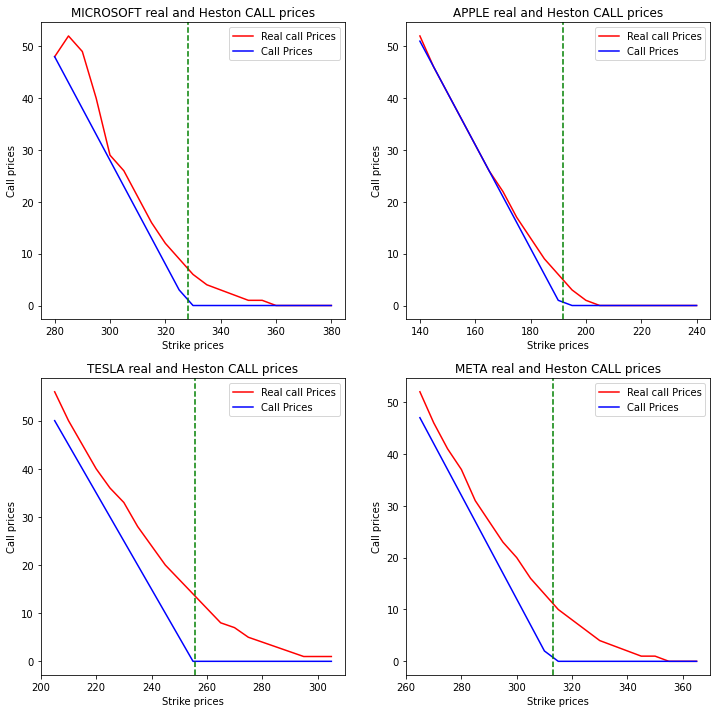

In [176]:
#fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(6, 12))
fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (12,12) )
Tickers = [ 'MSFT', 'AAPL', 'TSLA', 'META']

ax[0,0].plot(K[0][:], real_call_prices[0][:], color='red', label='Real call Prices')
ax[0,0].plot(K[0][:], call_prices[0][:], color='blue', label='Call Prices')
ax[0,0].set_xlabel('Strike prices')
ax[0,0].set_ylabel('Call prices')
ax[0,0].set_title('MICROSOFT real and Heston CALL prices')
ax[0,0].legend(loc='upper right')
ax[0,0].axvline(x = S0[0], color = 'green' ,linestyle='--')

ax[0,1].plot(K[1][:], real_call_prices[1][:], color='red', label='Real call Prices')
ax[0,1].plot(K[1][:], call_prices[1][:], color='blue', label='Call Prices')
ax[0,1].set_xlabel('Strike prices')
ax[0,1].set_ylabel('Call prices')
ax[0,1].set_title('APPLE real and Heston CALL prices')
ax[0,1].legend(loc='upper right')
ax[0,1].axvline(x = S0[1], color = 'green' ,linestyle='--')

ax[1,0].plot(K[2][:], real_call_prices[2][:], color='red', label='Real call Prices')
ax[1,0].plot(K[2][:], call_prices[2][:], color='blue', label='Call Prices')
ax[1,0].set_xlabel('Strike prices')
ax[1,0].set_ylabel('Call prices')
ax[1,0].set_title('TESLA real and Heston CALL prices')
ax[1,0].legend(loc='upper right')
ax[1,0].axvline(x = S0[2], color = 'green' ,linestyle='--')

ax[1,1].plot(K[3][:], real_call_prices[3][:], color='red', label='Real call Prices')
ax[1,1].plot(K[3][:], call_prices[3][:], color='blue', label='Call Prices')
ax[1,1].set_xlabel('Strike prices')
ax[1,1].set_ylabel('Call prices')
ax[1,1].set_title('META real and Heston CALL prices')
ax[1,1].legend(loc='upper right')
ax[1,1].axvline(x = S0[3], color = 'green' ,linestyle='--')


plt.show()

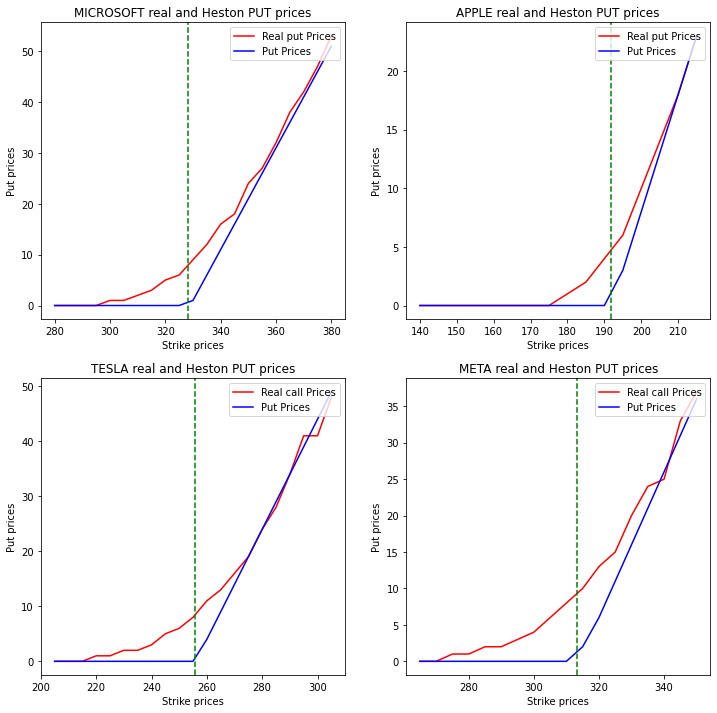

In [184]:

fig2, ax2 = plt.subplots(nrows=2, ncols=2,figsize = (12,12) )
Tickers = [ 'MSFT', 'AAPL', 'TSLA', 'META']

ax2[0,0].plot(K[0][:], real_put_prices[0][:], color='red', label='Real put Prices')
ax2[0,0].plot(K[0][:], put_prices[0][:], color='blue', label='Put Prices')
ax2[0,0].set_xlabel('Strike prices')
ax2[0,0].set_ylabel('Put prices')
ax2[0,0].set_title('MICROSOFT real and Heston PUT prices')
ax2[0,0].legend(loc='upper right')
ax2[0,0].axvline(x = S0[0], color = 'green' ,linestyle='--')

ax2[0,1].plot(K[1][:16], real_put_prices[1][:16], color='red', label='Real put Prices')
ax2[0,1].plot(K[1][:16], put_prices[1][:16], color='blue', label='Put Prices')
ax2[0,1].set_xlabel('Strike prices')
ax2[0,1].set_ylabel('Put prices')
ax2[0,1].set_title('APPLE real and Heston PUT prices')
ax2[0,1].legend(loc='upper right')
ax2[0,1].axvline(x = S0[1], color = 'green' ,linestyle='--')

ax2[1,0].plot(K[2][:], real_put_prices[2][:], color='red', label='Real put Prices')
ax2[1,0].plot(K[2][:], put_prices[2][:], color='blue', label='Put Prices')
ax2[1,0].set_xlabel('Strike prices')
ax2[1,0].set_ylabel('Put prices')
ax2[1,0].set_title('TESLA real and Heston PUT prices')
ax2[1,0].legend(loc='upper right')
ax2[1,0].axvline(x = S0[2], color = 'green' ,linestyle='--')

ax2[1,1].plot(K[3][:18], real_put_prices[3][:18], color='red', label='Real put Prices')
ax2[1,1].plot(K[3][:18], put_prices[3][:18], color='blue', label='Put Prices')
ax2[1,1].set_xlabel('Strike prices')
ax2[1,1].set_ylabel('Put prices')
ax2[1,1].set_title('META real and Heston PUT prices')
ax2[1,1].legend(loc='upper right')
ax2[1,1].axvline(x = S0[3], color = 'green' ,linestyle='--')



plt.show()

We draw same graphs for other models 

In [188]:
#Black Scholes

black_scholes_call = np.full((nb_companies,nb_strike_prices+1), fill_value=0)
for i in range(nb_companies) : 
    black_scholes_call[i,:] = [companies[i].Options[j].black_scholes_model(companies[i].S0,companies[i].historical_volatility) for j in range(nb_strike_prices+1)]

black_scholes_put = np.full((nb_companies,nb_strike_prices+1), fill_value=0)
for i in range(nb_companies) : 
    black_scholes_put[i,:] = [companies[i].Options[j].black_scholes_model(companies[i].S0,companies[i].historical_volatility) for j in range(nb_strike_prices+1,2*(nb_strike_prices+1))]

# Monte Carlo simulation with constant volatility 

monte_carlo_call = np.full((nb_companies,nb_strike_prices+1), fill_value=0)
for i in range(nb_companies) : 
    monte_carlo_call[i,:] = [companies[i].Options[j].monte_carlo_simulation(companies[i].S0,companies[i].historical_volatility) for j in range(nb_strike_prices+1)]

monte_carlo_put = np.full((nb_companies,nb_strike_prices+1), fill_value=0)
for i in range(nb_companies) : 
    monte_carlo_put[i,:] = [companies[i].Options[j].monte_carlo_simulation(companies[i].S0,companies[i].historical_volatility) for j in range(nb_strike_prices+1,2*(nb_strike_prices+1))]

# Binomial simulation

binomial_call = np.full((nb_companies,nb_strike_prices+1), fill_value=0)
for i in range(nb_companies) : 
    binomial_call[i,:] = [companies[i].Options[j].binomial_model(companies[i].S0,40,companies[i].historical_volatility) for j in range(nb_strike_prices+1)]

binomial_put = np.full((nb_companies,nb_strike_prices+1), fill_value=0)
for i in range(nb_companies) : 
    binomial_put[i,:] = [companies[i].Options[j].binomial_model(companies[i].S0,40,companies[i].historical_volatility) for j in range(nb_strike_prices+1,2*(nb_strike_prices+1))]



Plotting for each model

Black Scholes for CALL

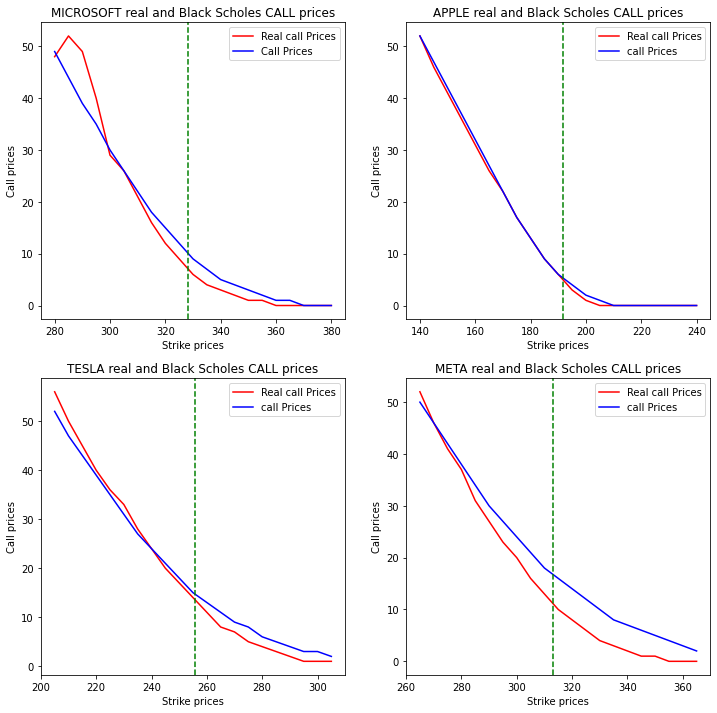

In [189]:
#Black Scholes Call

fig3, ax3 = plt.subplots(nrows=2, ncols=2,figsize = (12,12) )
Tickers = [ 'MSFT', 'AAPL', 'TSLA', 'META']

ax3[0,0].plot(K[0][:], real_call_prices[0][:], color='red', label='Real call Prices')
ax3[0,0].plot(K[0][:], black_scholes_call[0][:], color='blue', label='Call Prices')
ax3[0,0].set_xlabel('Strike prices')
ax3[0,0].set_ylabel('Call prices')
ax3[0,0].set_title('MICROSOFT real and Black Scholes CALL prices')
ax3[0,0].legend(loc='upper right')
ax3[0,0].axvline(x = S0[0], color = 'green' ,linestyle='--')

ax3[0,1].plot(K[1][:], real_call_prices[1][:], color='red', label='Real call Prices')
ax3[0,1].plot(K[1][:], black_scholes_call[1][:], color='blue', label='call Prices')
ax3[0,1].set_xlabel('Strike prices')
ax3[0,1].set_ylabel('Call prices')
ax3[0,1].set_title('APPLE real and Black Scholes CALL prices')
ax3[0,1].legend(loc='upper right')
ax3[0,1].axvline(x = S0[1], color = 'green' ,linestyle='--')

ax3[1,0].plot(K[2][:], real_call_prices[2][:], color='red', label='Real call Prices')
ax3[1,0].plot(K[2][:], black_scholes_call[2][:], color='blue', label='call Prices')
ax3[1,0].set_xlabel('Strike prices')
ax3[1,0].set_ylabel('Call prices')
ax3[1,0].set_title('TESLA real and Black Scholes CALL prices')
ax3[1,0].legend(loc='upper right')
ax3[1,0].axvline(x = S0[2], color = 'green' ,linestyle='--')

ax3[1,1].plot(K[3][:], real_call_prices[3][:], color='red', label='Real call Prices')
ax3[1,1].plot(K[3][:], black_scholes_call[3][:], color='blue', label='call Prices')
ax3[1,1].set_xlabel('Strike prices')
ax3[1,1].set_ylabel('Call prices')
ax3[1,1].set_title('META real and Black Scholes CALL prices')
ax3[1,1].legend(loc='upper right')
ax3[1,1].axvline(x = S0[3], color = 'green' ,linestyle='--')

Black Scholes for PUT

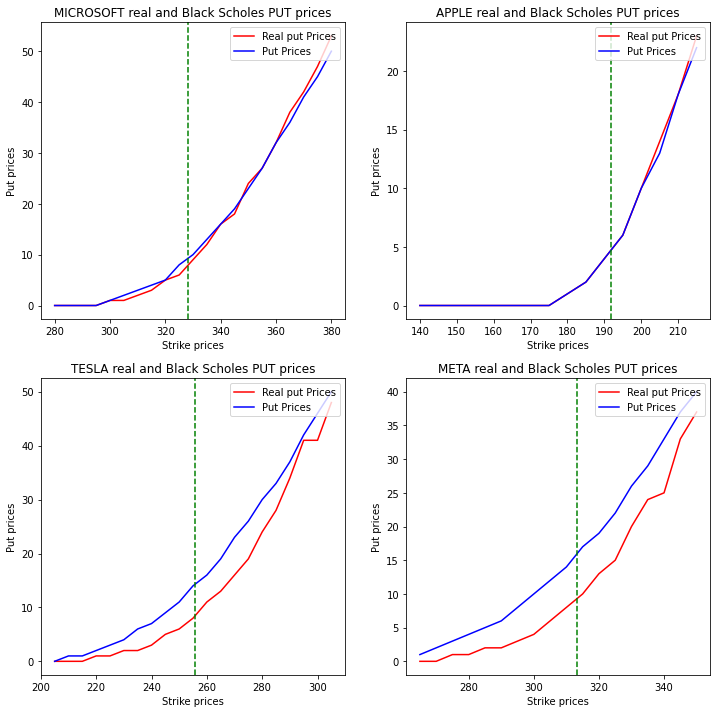

In [197]:
#Black Scholes Put


fig2, ax2 = plt.subplots(nrows=2, ncols=2,figsize = (12,12) )
Tickers = [ 'MSFT', 'AAPL', 'TSLA', 'META']

ax2[0,0].plot(K[0][:], real_put_prices[0][:], color='red', label='Real put Prices')
ax2[0,0].plot(K[0][:], black_scholes_put[0][:], color='blue', label='Put Prices')
ax2[0,0].set_xlabel('Strike prices')
ax2[0,0].set_ylabel('Put prices')
ax2[0,0].set_title('MICROSOFT real and Black Scholes PUT prices')
ax2[0,0].legend(loc='upper right')
ax2[0,0].axvline(x = S0[0], color = 'green' ,linestyle='--')

ax2[0,1].plot(K[1][:16], real_put_prices[1][:16], color='red', label='Real put Prices')
ax2[0,1].plot(K[1][:16], black_scholes_put[1][:16], color='blue', label='Put Prices')
ax2[0,1].set_xlabel('Strike prices')
ax2[0,1].set_ylabel('Put prices')
ax2[0,1].set_title('APPLE real and Black Scholes PUT prices')
ax2[0,1].legend(loc='upper right')
ax2[0,1].axvline(x = S0[1], color = 'green' ,linestyle='--')

ax2[1,0].plot(K[2][:], real_put_prices[2][:], color='red', label='Real put Prices')
ax2[1,0].plot(K[2][:], black_scholes_put[2][:], color='blue', label='Put Prices')
ax2[1,0].set_xlabel('Strike prices')
ax2[1,0].set_ylabel('Put prices')
ax2[1,0].set_title('TESLA real and Black Scholes PUT prices')
ax2[1,0].legend(loc='upper right')
ax2[1,0].axvline(x = S0[2], color = 'green' ,linestyle='--')

ax2[1,1].plot(K[3][:18], real_put_prices[3][:18], color='red', label='Real put Prices')
ax2[1,1].plot(K[3][:18], black_scholes_put[3][:18], color='blue', label='Put Prices')
ax2[1,1].set_xlabel('Strike prices')
ax2[1,1].set_ylabel('Put prices')
ax2[1,1].set_title('META real and Black Scholes PUT prices')
ax2[1,1].legend(loc='upper right')
ax2[1,1].axvline(x = S0[3], color = 'green' ,linestyle='--')



plt.show()

Monte Carlo with constant volatility for CALL

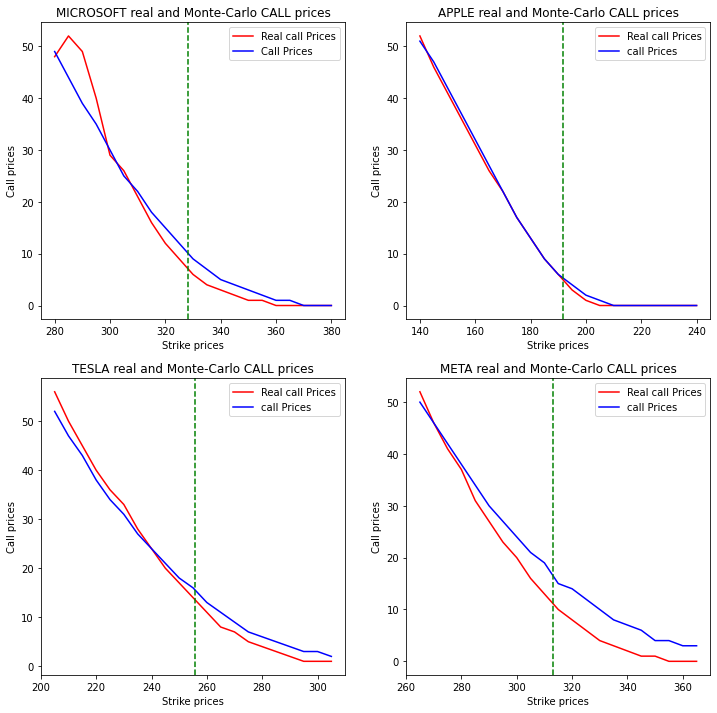

In [191]:
# Monte Carlo with constant volatility for CALL


fig3, ax3 = plt.subplots(nrows=2, ncols=2,figsize = (12,12) )
Tickers = [ 'MSFT', 'AAPL', 'TSLA', 'META']

ax3[0,0].plot(K[0][:], real_call_prices[0][:], color='red', label='Real call Prices')
ax3[0,0].plot(K[0][:], monte_carlo_call[0][:], color='blue', label='Call Prices')
ax3[0,0].set_xlabel('Strike prices')
ax3[0,0].set_ylabel('Call prices')
ax3[0,0].set_title('MICROSOFT real and Monte-Carlo CALL prices')
ax3[0,0].legend(loc='upper right')
ax3[0,0].axvline(x = S0[0], color = 'green' ,linestyle='--')

ax3[0,1].plot(K[1][:], real_call_prices[1][:], color='red', label='Real call Prices')
ax3[0,1].plot(K[1][:], monte_carlo_call[1][:], color='blue', label='call Prices')
ax3[0,1].set_xlabel('Strike prices')
ax3[0,1].set_ylabel('Call prices')
ax3[0,1].set_title('APPLE real and Monte-Carlo CALL prices')
ax3[0,1].legend(loc='upper right')
ax3[0,1].axvline(x = S0[1], color = 'green' ,linestyle='--')

ax3[1,0].plot(K[2][:], real_call_prices[2][:], color='red', label='Real call Prices')
ax3[1,0].plot(K[2][:], monte_carlo_call[2][:], color='blue', label='call Prices')
ax3[1,0].set_xlabel('Strike prices')
ax3[1,0].set_ylabel('Call prices')
ax3[1,0].set_title('TESLA real and Monte-Carlo CALL prices')
ax3[1,0].legend(loc='upper right')
ax3[1,0].axvline(x = S0[2], color = 'green' ,linestyle='--')

ax3[1,1].plot(K[3][:], real_call_prices[3][:], color='red', label='Real call Prices')
ax3[1,1].plot(K[3][:], monte_carlo_call[3][:], color='blue', label='call Prices')
ax3[1,1].set_xlabel('Strike prices')
ax3[1,1].set_ylabel('Call prices')
ax3[1,1].set_title('META real and Monte-Carlo CALL prices')
ax3[1,1].legend(loc='upper right')
ax3[1,1].axvline(x = S0[3], color = 'green' ,linestyle='--')

Monte Carlo with constant volatility for PUT

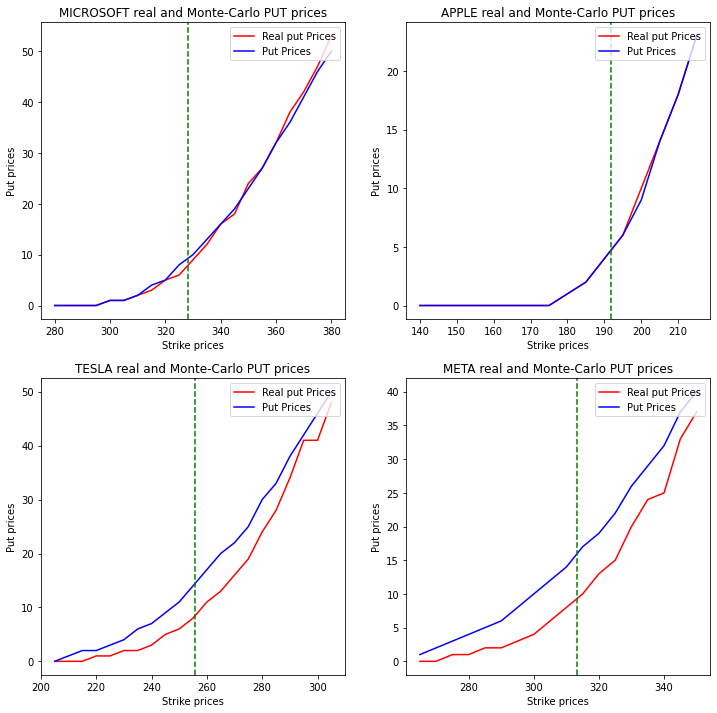

In [196]:
# Monte Carlo with constant volatility for PUT

#Black Scholes Put


fig2, ax2 = plt.subplots(nrows=2, ncols=2,figsize = (12,12) )
Tickers = [ 'MSFT', 'AAPL', 'TSLA', 'META']

ax2[0,0].plot(K[0][:], real_put_prices[0][:], color='red', label='Real put Prices')
ax2[0,0].plot(K[0][:], monte_carlo_put[0][:], color='blue', label='Put Prices')
ax2[0,0].set_xlabel('Strike prices')
ax2[0,0].set_ylabel('Put prices')
ax2[0,0].set_title('MICROSOFT real and Monte-Carlo PUT prices')
ax2[0,0].legend(loc='upper right')
ax2[0,0].axvline(x = S0[0], color = 'green' ,linestyle='--')

ax2[0,1].plot(K[1][:16], real_put_prices[1][:16], color='red', label='Real put Prices')
ax2[0,1].plot(K[1][:16], monte_carlo_put[1][:16], color='blue', label='Put Prices')
ax2[0,1].set_xlabel('Strike prices')
ax2[0,1].set_ylabel('Put prices')
ax2[0,1].set_title('APPLE real and Monte-Carlo PUT prices')
ax2[0,1].legend(loc='upper right')
ax2[0,1].axvline(x = S0[1], color = 'green' ,linestyle='--')

ax2[1,0].plot(K[2][:], real_put_prices[2][:], color='red', label='Real put Prices')
ax2[1,0].plot(K[2][:], monte_carlo_put[2][:], color='blue', label='Put Prices')
ax2[1,0].set_xlabel('Strike prices')
ax2[1,0].set_ylabel('Put prices')
ax2[1,0].set_title('TESLA real and Monte-Carlo PUT prices')
ax2[1,0].legend(loc='upper right')
ax2[1,0].axvline(x = S0[2], color = 'green' ,linestyle='--')

ax2[1,1].plot(K[3][:18], real_put_prices[3][:18], color='red', label='Real put Prices')
ax2[1,1].plot(K[3][:18], monte_carlo_put[3][:18], color='blue', label='Put Prices')
ax2[1,1].set_xlabel('Strike prices')
ax2[1,1].set_ylabel('Put prices')
ax2[1,1].set_title('META real and Monte-Carlo PUT prices')
ax2[1,1].legend(loc='upper right')
ax2[1,1].axvline(x = S0[3], color = 'green' ,linestyle='--')



plt.show()

Binomial model for CALL options

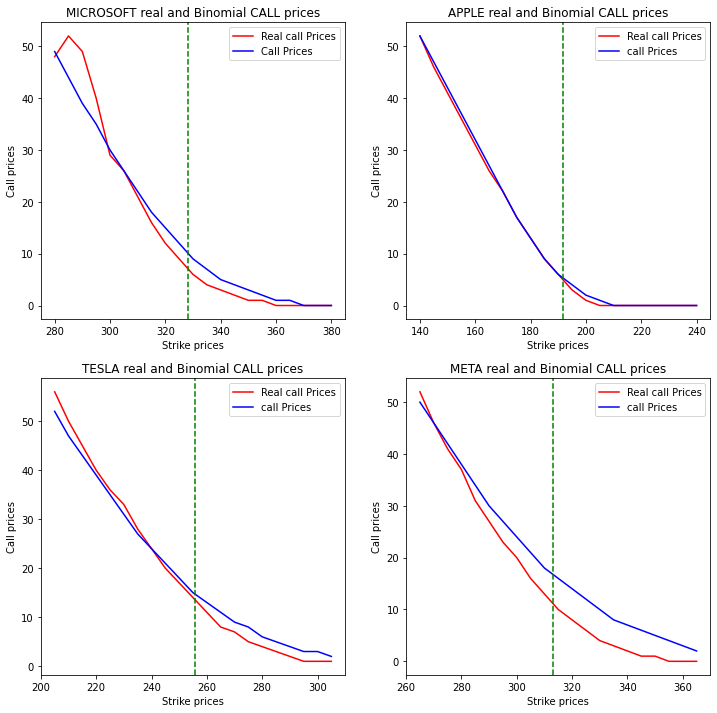

In [193]:
fig3, ax3 = plt.subplots(nrows=2, ncols=2,figsize = (12,12) )
Tickers = [ 'MSFT', 'AAPL', 'TSLA', 'META']

ax3[0,0].plot(K[0][:], real_call_prices[0][:], color='red', label='Real call Prices')
ax3[0,0].plot(K[0][:], binomial_call[0][:], color='blue', label='Call Prices')
ax3[0,0].set_xlabel('Strike prices')
ax3[0,0].set_ylabel('Call prices')
ax3[0,0].set_title('MICROSOFT real and Binomial CALL prices')
ax3[0,0].legend(loc='upper right')
ax3[0,0].axvline(x = S0[0], color = 'green' ,linestyle='--')

ax3[0,1].plot(K[1][:], real_call_prices[1][:], color='red', label='Real call Prices')
ax3[0,1].plot(K[1][:], binomial_call[1][:], color='blue', label='call Prices')
ax3[0,1].set_xlabel('Strike prices')
ax3[0,1].set_ylabel('Call prices')
ax3[0,1].set_title('APPLE real and Binomial CALL prices')
ax3[0,1].legend(loc='upper right')
ax3[0,1].axvline(x = S0[1], color = 'green' ,linestyle='--')

ax3[1,0].plot(K[2][:], real_call_prices[2][:], color='red', label='Real call Prices')
ax3[1,0].plot(K[2][:], binomial_call[2][:], color='blue', label='call Prices')
ax3[1,0].set_xlabel('Strike prices')
ax3[1,0].set_ylabel('Call prices')
ax3[1,0].set_title('TESLA real and Binomial CALL prices')
ax3[1,0].legend(loc='upper right')
ax3[1,0].axvline(x = S0[2], color = 'green' ,linestyle='--')

ax3[1,1].plot(K[3][:], real_call_prices[3][:], color='red', label='Real call Prices')
ax3[1,1].plot(K[3][:], binomial_call[3][:], color='blue', label='call Prices')
ax3[1,1].set_xlabel('Strike prices')
ax3[1,1].set_ylabel('Call prices')
ax3[1,1].set_title('META real and Binomial CALL prices')
ax3[1,1].legend(loc='upper right')
ax3[1,1].axvline(x = S0[3], color = 'green' ,linestyle='--')

Binomial for PUT options

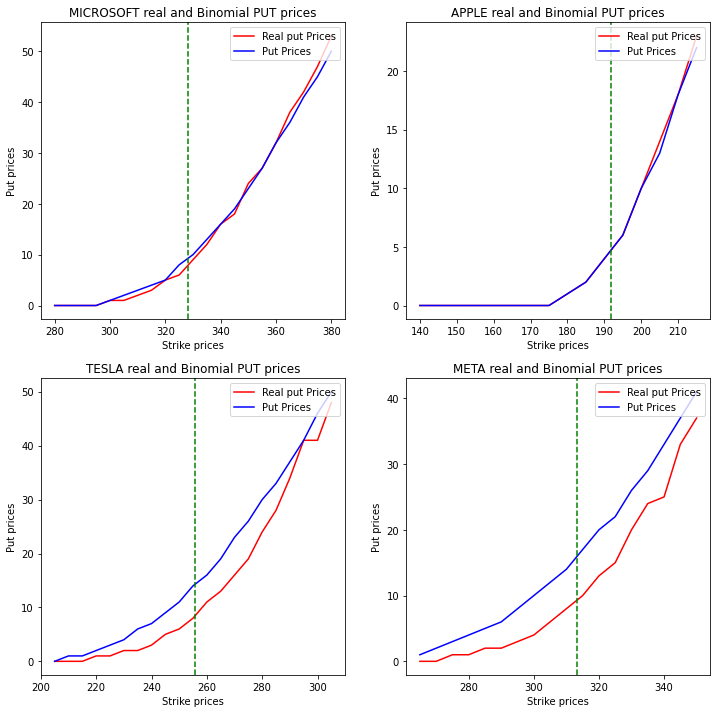

In [195]:
fig2, ax2 = plt.subplots(nrows=2, ncols=2,figsize = (12,12) )
Tickers = [ 'MSFT', 'AAPL', 'TSLA', 'META']

ax2[0,0].plot(K[0][:], real_put_prices[0][:], color='red', label='Real put Prices')
ax2[0,0].plot(K[0][:], binomial_put[0][:], color='blue', label='Put Prices')
ax2[0,0].set_xlabel('Strike prices')
ax2[0,0].set_ylabel('Put prices')
ax2[0,0].set_title('MICROSOFT real and Binomial PUT prices')
ax2[0,0].legend(loc='upper right')
ax2[0,0].axvline(x = S0[0], color = 'green' ,linestyle='--')

ax2[0,1].plot(K[1][:16], real_put_prices[1][:16], color='red', label='Real put Prices')
ax2[0,1].plot(K[1][:16], binomial_put[1][:16], color='blue', label='Put Prices')
ax2[0,1].set_xlabel('Strike prices')
ax2[0,1].set_ylabel('Put prices')
ax2[0,1].set_title('APPLE real and Binomial PUT prices')
ax2[0,1].legend(loc='upper right')
ax2[0,1].axvline(x = S0[1], color = 'green' ,linestyle='--')

ax2[1,0].plot(K[2][:], real_put_prices[2][:], color='red', label='Real put Prices')
ax2[1,0].plot(K[2][:], binomial_put[2][:], color='blue', label='Put Prices')
ax2[1,0].set_xlabel('Strike prices')
ax2[1,0].set_ylabel('Put prices')
ax2[1,0].set_title('TESLA real and Binomial PUT prices')
ax2[1,0].legend(loc='upper right')
ax2[1,0].axvline(x = S0[2], color = 'green' ,linestyle='--')

ax2[1,1].plot(K[3][:18], real_put_prices[3][:18], color='red', label='Real put Prices')
ax2[1,1].plot(K[3][:18], binomial_put[3][:18], color='blue', label='Put Prices')
ax2[1,1].set_xlabel('Strike prices')
ax2[1,1].set_ylabel('Put prices')
ax2[1,1].set_title('META real and Binomial PUT prices')
ax2[1,1].legend(loc='upper right')
ax2[1,1].axvline(x = S0[3], color = 'green' ,linestyle='--')



plt.show()